In [1]:
# Load the Drive helper and mount
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Change the below path to where the <training_data.zip> folder is on your Google Drive
!cp /content/drive/MyDrive/189_team_folder/training_data.zip /content/training_data.zip

In [3]:
!mkdir /content/dataset

In [4]:
!7z x /content/training_data.zip -o/content/dataset


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4373590188 bytes (4171 MiB)

Extracting archive: /content/training_data.zip
  0% 256 Open               6% 4352 Open               12% 8448 Open               20% 13568 Open                28% 18432 Open                33% 21760 Open                34% 22784 Open                37% 24832 Open                39% 25856 Open                44% 29184 Open                52% 34304 Open

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import imageio as iio
import os

import torch
import torch.nn as nn
from tqdm import tqdm

root_dir = "/content/dataset/training_data"
folders = os.listdir(root_dir)

In [6]:
# local imports 
import sys
# You will have to change the path for the <start_code_folder> as well to where the EE189 start code is located on your Drive
start_code_folder = "/content/drive/MyDrive/189_team_folder/starter_code"
sys.path.insert(0, start_code_folder)
from eval import *

# Reading in an Image from the Dataset

In [7]:
sample_img = iio.imread(os.path.join(root_dir, folders[10], "rgb", "rgb_101.png"))

<ipython-input-7-c3ddefb0ccb7>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  sample_img = iio.imread(os.path.join(root_dir, folders[10], "rgb", "rgb_101.png"))


In [8]:
# Get the shape
print(sample_img.shape)

(64, 64, 3)


In [ ]:
# Plot the image
plt.imshow(sample_img)

# Reading in the Groundtruth

In [10]:
ppg_sig = np.load(os.path.join(root_dir, folders[0], "ppg", "ppg.npy"))

In [11]:
# Length of Signal
print(ppg_sig.shape, ppg_sig.dtype)

(1790,) <U24


In [12]:
ppg_sig = ppg_sig.astype(np.float32)

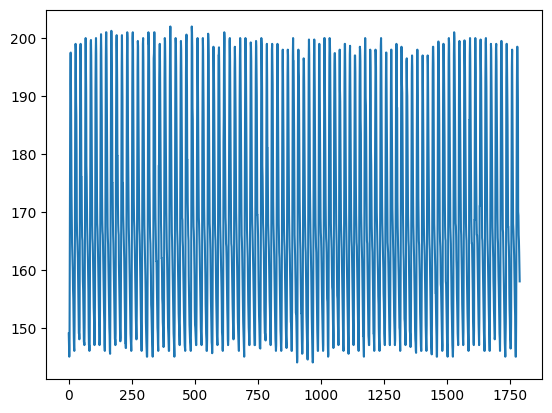

In [13]:
plt.figure()
plt.plot(ppg_sig)
plt.show()

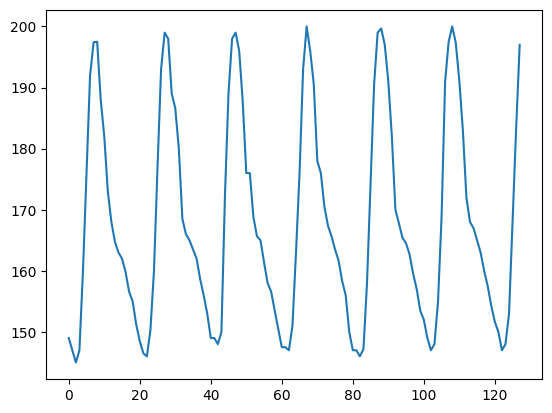

In [14]:
plt.figure()
plt.plot(ppg_sig[0:128])
plt.show()

# Naive Dataset Object

In [15]:
from torch.utils.data import Dataset, DataLoader
import imageio.v3 as imageio

def transform_img(img):
    """ Image Transform to be used for training and evaluation"""
    img = img/255.0  
    return img

class RGBData(Dataset):
    def __init__(self, datapath, datapaths, img_func, recording_str="rgb", ppg_str="ppg",
                 video_length = 1600, frame_length = 128, num_samps=20) -> None:
        
        # Number of samples to be created by oversampling one trial.
        self.num_samps = num_samps
        # Name of the files being read. Name depends on how the file was save. We have saved the file as rgbd_rgb
        self.id_str = recording_str
        self.ppg_str = ppg_str
        # Number of frames in the input video. (Requires all data-samples to have the same number of frames).
        self.video_length = video_length
        # Number of frames in the output tensor sample.
        self.frame_length = frame_length
        # Data structure for videos.
        self.datapath = datapath
        # Load videos and signals.
        self.video_list = datapaths
        # img transformation function 
        self.img_func = img_func

        self.signal_list = []
        # Load signals
        remove_folders = []
        for folder in self.video_list:
            file_path = os.path.join(datapath, folder)
            # Make a list of the folder that do not have the PPG signal.
            if(os.path.exists(file_path)):
                if(os.path.exists(os.path.join(file_path, "ppg", f"{self.ppg_str}.npy"))):
                    signal = np.load(os.path.join(file_path, "ppg", f"{self.ppg_str}.npy"))
                    self.signal_list.append(signal[0:video_length])
                else:
                    raise Exception("PPG file not found.")

        # Extract the stats for the vital signs.
        self.signal_list = np.array(self.signal_list, dtype=np.float32)
        self.vital_mean = np.mean(self.signal_list)
        self.vital_std = np.std(self.signal_list)
        # Normalize dataset
        self.signal_list = (self.signal_list - self.vital_mean)/self.vital_std

        # Create a list of video number and valid frame number to extract the data from.
        self.video_nums = np.arange(0, len(self.video_list))
        self.frame_nums = np.arange(0, self.video_length - frame_length)
        
        # Create all possible sampling combinations.
        self.all_idxs = []
        for num in self.video_nums:
            # Generate the start index.
            cur_frame_nums = np.random.randint(low=0, 
                                               high = self.video_length - frame_length, 
                                               size = self.num_samps)
            # Append all the start indices.
            for cur_frame_num in cur_frame_nums:
                self.all_idxs.append((num,cur_frame_num))
            
            
    def __len__(self):
        return int(len(self.all_idxs))

    def __getitem__(self, idx):
        # Get the video number and the starting frame index.
        video_number, frame_start = self.all_idxs[idx]
        # Get video frames for the output video tensor.
        # (Expects each sample to be stored in a folder with the sample name. Each frame is stored as a png)
        item = []
        for img_idx in range(self.frame_length):
            image_path = os.path.join(self.datapath, 
                                str(self.video_list[video_number]), "rgb", 
                                f"{self.id_str}_{frame_start+img_idx}.png")
            item.append(self.img_func(imageio.imread(image_path)))
        item = np.array(item, dtype=np.float32)

        # Add channel dim if no channels in image.
        if(len(item.shape) < 4): 
            item = np.expand_dims(item, axis=3)
        # Get signal.
        item_sig = self.signal_list[int(video_number)][int(frame_start):int(frame_start+self.frame_length)]
        
        return np.array(item), np.array(item_sig)

In [16]:
train_set = folders[:int(len(folders)*0.8)]
test_set = folders[int(len(folders)*0.8):]

train_dataset = RGBData(root_dir, train_set, img_func=transform_img)
test_dataset = RGBData(root_dir, test_set, img_func=transform_img)

batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
imgs, ppg_gt = train_dataset[0]

print(imgs.shape, ppg_gt.shape)

(128, 64, 64, 3) (128,)


# Pre processing

In [18]:
# Skin segmentation Model 1
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def skin_seg_2(input_image):
    # First lets resize the image to 512x512
    shape = input_image.shape
    input_image = Image.fromarray(input_image).resize((512, 512))
    model = torch.hub.load('pytorch/vision:v0.9.0', 'deeplabv3_resnet101', pretrained=True)
    model.eval()
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    input_tensor = preprocess(input_image)

    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)['out'][0]
    output_predictions = output.argmax(0)

    # Now make a mask and apply it to the image

    mask = output_predictions == 15
    mask = mask.cpu().numpy()
    mask = mask.astype(np.uint8)
    mask = mask * 255
    # The pixels from mask != 0  highlight the entire face, leaving out only whats left of the background.
    # but we only want the skin. What we can do is apply a clustering based approach.
    # Since most of the face is skin, we can cluster into 5 classes and then select the class that has the most pixels. This will be the skin class.
    # We can then use this class to create a mask for the skin.
    # Lets start by finding the indices of the skin class(aka the class with the most pixels)
    pixel_array = np.array(input_image).reshape(-1, 3)
    mask = mask.reshape(-1, 1)
    pixel_array = np.concatenate((pixel_array, mask), axis=1)

    kmeans = KMeans(n_clusters=5, random_state=0).fit(pixel_array)
    # Now we can get the class with the most pixels
    unique, counts = np.unique(kmeans.labels_, return_counts=True)
    skin_class = unique[np.argmax(counts)]
    # Now we can create a mask for the skin
    skin_mask = kmeans.labels_ == skin_class
    skin_mask = skin_mask.reshape(512, 512)
    skin_mask = skin_mask.astype(np.uint8)
    skin_mask = skin_mask * 255
    # Now we can apply the mask to the image
    input_image = input_image.convert('RGB')
    input_image = np.array(input_image)
    input_image[skin_mask == 0] = 0

    # Finally, we can resize the image back to the original size
    input_image = Image.fromarray(input_image)
    input_image = input_image.resize((shape[1], shape[0]))

    # remake it a numpy array
    input_image = np.array(input_image)
    
    return input_image


In [19]:
# Skin segmentation Model 2
# Lets put it all together. We will make a function that takes in an image and returns the cropped image. 
# imports
# Pre
import numpy as np 
import matplotlib.pyplot as plt

import imageio as iio
import os

import torch
import torch.nn as nn
from tqdm import tqdm

import cv2
from pylab import rcParams
import urllib.request as urlreq

LBFmodel_url = "https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml"
LBFmodel = "lbfmodel.yaml"
urlreq.urlretrieve(LBFmodel_url, LBFmodel)
# Create a landmark detector on cv2
landmark_detector = cv2.face.createFacemarkLBF()
landmark_detector.loadModel(LBFmodel)


def skin_seg_2(img):
    # convert to BGR
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # Check the number of channels
    # We have a 4 channel image, we need to convert it to 3 channel
    img = img[:,:,:3]
    # show the image
    grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    h, w = img.shape[:2]
    bbox = (int(w*0.05), int(h*0.05), int(w*0.9), int(h*0.9))
    # bound the image
    img_n = grayscale[bbox[1]:bbox[3], bbox[0]:bbox[2]]

    _, landmarks = landmark_detector.fit(grayscale, np.array([cv2.boundingRect(img_n)]))

    landmark = landmarks[0][0]
    # Now we have a list of landmarks.
    # Lets draw a line between each point and the next point in the list
    # Lets first draw a circle at each point
    # for point in landmark:
    #     cv2.circle(img, ( int(point[0]), int(point[1])), 1, (0, 0, 255), -1)
    # for i in range(len(landmark)-1):
    #     cv2.line(img, (int(landmark[i][0]), int(landmark[i][1])), (int(landmark[i+1][0]), int(landmark[i+1][1])), (0, 0, 255), 1)

    
    left_eye = landmark[36:42]
    right_eye = landmark[42:48]
    nose = landmark[27:36]
    mouth = landmark[48:60]
    left_eyebrow = landmark[17:22]
    right_eyebrow = landmark[22:27]
    chin = landmark[8:17]
    # jaw = landmark[0:8] # not used
    # contour = landmark[60:68] # not used

    cv2.fillPoly(img, [left_eye.astype(int)], (0, 0, 0))
    for i in range(len(left_eye)-1):
        cv2.line(img, (int(left_eye[i][0]), int(left_eye[i][1])), (int(left_eye[i+1][0]), int(left_eye[i+1][1])), (0, 0, 0), 2)
    cv2.fillPoly(img, [right_eye.astype(int)], (0, 0, 0))
    for i in range(len(right_eye)-1):
        cv2.line(img, (int(right_eye[i][0]), int(right_eye[i][1])), (int(right_eye[i+1][0]), int(right_eye[i+1][1])), (0, 0, 0), 2)

    # Lets fill in the mouth
    cv2.fillPoly(img, [mouth.astype(int)], (0, 0, 0))
    
    # Lets fill in the nose
    cv2.fillPoly(img, [nose.astype(int)], (0, 0, 0))
    for i in range(len(nose)-1):
        cv2.line(img, (int(nose[i][0]), int(nose[i][1])), (int(nose[i+1][0]), int(nose[i+1][1])), (0, 0, 0), 2)


    # Lets fill in the left eyebrow
    for i in range(len(left_eyebrow)-1):
        cv2.line(img, (int(left_eyebrow[i][0]), int(left_eyebrow[i][1])), (int(left_eyebrow[i+1][0]), int(left_eyebrow[i+1][1])), (0, 0, 0), 2)

    # Lets fill in the right eyebrow
    for i in range(len(right_eyebrow)-1):
        cv2.line(img, (int(right_eyebrow[i][0]), int(right_eyebrow[i][1])), (int(right_eyebrow[i+1][0]), int(right_eyebrow[i+1][1])), (0, 0, 0), 2) 

    # back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

# Naive 2D

In [20]:
class CNN2D_rppg(nn.Module):

    def __init__(self, sequence_length=64, in_channels=3, device=torch.device("cuda"), 
                 num_filters=16, kernel_size=3, pool_size=(2, 2), nb_dense=128):
        """Definition of CNN2D_rppg.
        Args:
          in_channels: the number of input channel. Default: 3
        Returns:
          CNN2D_rppg model.
        """
        super(CNN2D_rppg, self).__init__()

        self.sequence_length=sequence_length
        self.use_gpu = True
        self.device = device
        
        # nn.Sequential is one method of defining models, you can read or look online 
        # for other styles of defining models if you like. 
        all_layers = []
        # CNN layers
        for i in range(5):
            all_layers.append(nn.Conv2d(in_channels, num_filters, kernel_size, stride=1, padding=1, bias=True))
            all_layers.append(nn.Tanh())
            all_layers.append(nn.MaxPool2d(pool_size))
            in_channels = num_filters
            num_filters = num_filters * 2

        # Dense layers
        all_layers.append(nn.Flatten())
        all_layers.append(nn.Linear(1024, nb_dense, bias=True))
        all_layers.append(nn.Tanh())
        all_layers.append(nn.Linear(nb_dense, 1, bias=True))

        self.model = nn.Sequential(*all_layers)

    def forward(self, inputs, params=None):
        # Notice how the inputs are converted to Tensors and reshaped within the forward pass.
        # Typically, it is done outside of the forward pass, but since different projects may have 
        # different input shapes, we leave it to you to define it within here. 
        # That way, the evaluation function will work for everyone. 
        

        inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        inputs = torch.squeeze(inputs, dim=0)
        inputs = torch.permute(inputs, dims=(0,3,1,2))
        print(inputs.shape)

        # Model Begins:
        diff_input = (inputs[1:, :, :, :] - inputs[:-1, :, :, :])
        diff_input = diff_input / torch.std(diff_input)
        print(diff_input.shape)
        out = self.model(diff_input)

        # Output needs to be transformed for better training
        # All steps are fully differentiable 
        # 1. Integrate
        out = torch.cumsum(out, dim=0)
        # 2. Mean Removal
        out = out - torch.mean(out)
        # 3. Linear Detrend
        x = torch.arange(0, out.shape[0], 1, dtype=torch.float32, device=torch.device('cuda:0'))
        x = x - torch.mean(x)
        x = torch.unsqueeze(x, 1)
        x_inv = 1/torch.sum(torch.multiply(x, x)) * torch.sum(x * out)
        out = out - x_inv * x
        out = out / (torch.std(out)+1e-4)

        return out

# 2D CNN model with Color Channel Reduction

In [21]:
class CNN2D_rppg(nn.Module):

    def __init__(self, sequence_length=64, in_channels=1, device=torch.device("cuda"), num_filters=16, kernel_size=3, pool_size=(2, 2), nb_dense=128):

        super(CNN2D_rppg, self).__init__()

        self.sequence_length=sequence_length
        self.use_gpu = True
        self.device = device

        # New color layer model
        # 3 direction vectors that can be parameterized
        self.color_layer = nn.Parameter(torch.tensor([0.531 , 0.59, 0.6], dtype=torch.float32, device=self.device), requires_grad=True)

        self.cnn1 = nn.Conv2d(in_channels, num_filters, kernel_size, stride=1, padding=1, bias=True)
        self.tanh1 = nn.Tanh()
        self.maxpool1 = nn.MaxPool2d(pool_size)

        self.cnn2 = nn.Conv2d(num_filters, num_filters*2, kernel_size, stride=1, padding=1, bias=True)
        self.tanh2 = nn.Tanh()
        self.maxpool2 = nn.MaxPool2d(pool_size)
        
        self.cnn3 = nn.Conv2d(num_filters*2, num_filters*4, kernel_size, stride=1, padding=1, bias=True)
        self.tanh3 = nn.Tanh()
        self.maxpool3 = nn.MaxPool2d(pool_size)

        self.cnn4 = nn.Conv2d(num_filters*4, num_filters*8, kernel_size, stride=1, padding=1, bias=True)
        self.tanh4 = nn.Tanh()
        self.maxpool4 = nn.MaxPool2d(pool_size)

        self.cnn5 = nn.Conv2d(num_filters*8, num_filters*16, kernel_size, stride=1, padding=1, bias=True)
        self.tanh5 = nn.Tanh()
        self.maxpool5 = nn.MaxPool2d(pool_size)

        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(1024, nb_dense, bias=True)
        self.tanh6 = nn.Tanh()
        self.dense2 = nn.Linear(nb_dense, 1, bias=True)

        self.model = nn.Sequential(self.cnn1, self.tanh1, self.maxpool1, self.cnn2, self.tanh2, self.maxpool2, self.cnn3, self.tanh3, self.maxpool3, self.cnn4, self.tanh4, self.maxpool4, self.cnn5, self.tanh5, self.maxpool5, self.flatten, self.dense1, self.tanh6, self.dense2)

    def forward(self, inputs, params=None):      

        # inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        # inputs = torch.squeeze(inputs, dim=0)
        # inputs = torch.permute(inputs, dims=(0,3,1,2))

        # # Model Begins:
        # diff_input = (inputs[1:, :, :, :] - inputs[:-1, :, :, :])
        # diff_input = diff_input / torch.std(diff_input)
        # out = self.model(diff_input)

        inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        inputs = torch.squeeze(inputs, dim=0)
        inputs = torch.einsum('ijkl, l -> ijk', inputs, self.color_layer)

        # # Model Begins:
        diff_input = (inputs[1:, :, :] - inputs[:-1, :, :])
        diff_input = diff_input / torch.std(diff_input)
        diff_input = torch.unsqueeze(diff_input, dim=1)
        out = self.model(diff_input)

        # 1. Integrate
        out = torch.cumsum(out, dim=0)
        # 2. Mean Removal
        out = out - torch.mean(out)
        # 3. Linear Detrend
        x = torch.arange(0, out.shape[0], 1, dtype=torch.float32, device=torch.device('cuda:0'))
        x = x - torch.mean(x)
        x = torch.unsqueeze(x, 1)
        x_inv = 1/torch.sum(torch.multiply(x, x)) * torch.sum(x * out)
        out = out - x_inv * x
        out = out / (torch.std(out)+1e-4)

        return out

# 3D CNN

In [22]:
class CNN3D_rppg_k(nn.Module):
# todo: activation layers
    def __init__(self, sequence_length=64, in_channels=3, device=torch.device("cuda"), 
                 num_filters=16, kernel_size=3, pool_size=(2, 2), nb_dense=128):
        """Definition of CNN3D_rppg.
        Args:
          in_channels: the number of input channel. Default: 3
        Returns:
          CNN3D_rppg model.
        """
        super(CNN3D_rppg_k, self).__init__()

        self.sequence_length=sequence_length
        self.use_gpu = True
        self.device = device
        
        self.cnn1 = torch.nn.Conv3d(3, 32, kernel_size=3, padding=1)
        self.bn_layer1 = torch.nn.BatchNorm3d(32)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn2 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer2 = torch.nn.BatchNorm3d(32)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn3 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer3 = torch.nn.BatchNorm3d(32)
        self.relu3 = torch.nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn4 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer4 = torch.nn.BatchNorm3d(32)
        self.relu4 = torch.nn.ReLU()
        self.maxpool4 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn5 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer5 = torch.nn.BatchNorm3d(32)
        self.relu5 = torch.nn.ReLU()
        self.maxpool5 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))
        
        self.cnn6 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer6 = torch.nn.BatchNorm3d(32)
        self.relu6 = torch.nn.ReLU()
        self.maxpool6 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.finalcnn = torch.nn.Conv1d(32, 1, kernel_size=3, padding=1)
        # self.bn_finallayer = torch.nn.BatchNorm3d(1)

    def forward(self, inputs, params=None):
        # Notice how the inputs are converted to Tensors and reshaped within the forward pass.
        # Typically, it is done outside of the forward pass, but since different projects may have 
        # different input shapes, we leave it to you to define it within here. 
        # That way, the evaluation function will work for everyone. 
        # inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        # inputs = torch.squeeze(inputs, dim=0)
        # inputs = torch.permute(inputs, dims=(0,3,1,2))

        # inputs = (BxTxHxWxC)
        #new_input = (BxCxTxHxW)

        inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)

        x = torch.permute(inputs, dims=tuple(torch.tensor([0, 4, 1, 2, 3])))

        x = self.cnn1(x)
        x = self.bn_layer1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.bn_layer2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = self.bn_layer3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.cnn4(x)
        x = self.bn_layer4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.cnn5(x)
        x = self.bn_layer5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)

        x = self.cnn6(x)
        x = self.bn_layer6(x)
        x = self.relu6(x)
        x = self.maxpool6(x)

        x = torch.squeeze(x) 

        x = self.finalcnn(x)
        # x = self.bn_finallayer(x)
        # x = relu(x)
        x = torch.squeeze(x)

        outputs = x

        # # Sanjits edits
        # print(outputs.shape)

        # out = output_ppg.cpu().detach().numpy()
        # mean = np.mean(out)
        # std = np.std(out)
        # dist_param = 5
        # for each in range(len(out)):
        #     if out[each].any() > mean + dist_param*std or out[each].any() < mean - dist_param*std:
        #         outputs[each] = torch.from_numpy(np.array(mean))

        # print(outputs.shape)

        # End of Sanjits edits

        return outputs

# 3D CNN with Color reduced channel

In [23]:
from torch import nn
import numpy as np
import torch
import torch.nn.functional as F
import os
import torch.nn as nn

def transform_img(img):
    """ Image Transform to be used for training and evaluation
        This function is called by the dataloader to transform the image before it is passed to the model.

    Args:
        img (np.array): RGB uint8 image

    Returns:
        transformed_img (np.array): Transformed image
    """
    img = img/255.0
    return img
class CNN3D_rppg_d(nn.Module):
# todo: activation layers
    def __init__(self, sequence_length=64, in_channels=4, device=torch.device("cuda"), 
                 num_filters=16, kernel_size=3, pool_size=(2, 2), nb_dense=128):
        """Definition of CNN3D_rppg.
        Args:
          in_channels: the number of input channel. Default: 3
        Returns:
          CNN3D_rppg model.
        """
        super(CNN3D_rppg_d, self).__init__()

        self.sequence_length=sequence_length
        self.use_gpu = True
        self.device = device

        self.color_layer = nn.Parameter(torch.tensor([0.531 , 0.59, 0.6], dtype=torch.float32, device=self.device), requires_grad=True)
        
        self.cnn1 = torch.nn.Conv3d(in_channels, 32, kernel_size=3, padding=1)
        self.bn_layer1 = torch.nn.BatchNorm3d(32)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn2 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer2 = torch.nn.BatchNorm3d(32)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn3 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer3 = torch.nn.BatchNorm3d(32)
        self.relu3 = torch.nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn4 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer4 = torch.nn.BatchNorm3d(32)
        self.relu4 = torch.nn.ReLU()
        self.maxpool4 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn5 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer5 = torch.nn.BatchNorm3d(32)
        self.relu5 = torch.nn.ReLU()
        self.maxpool5 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))
        
        self.cnn6 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer6 = torch.nn.BatchNorm3d(32)
        self.relu6 = torch.nn.ReLU()
        self.maxpool6 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.finalcnn = torch.nn.Conv1d(32, 1, kernel_size=3, padding=1)
        # self.bn_finallayer = torch.nn.BatchNorm3d(1)

    def forward(self, inputs, params=None):
        # Notice how the inputs are converted to Tensors and reshaped within the forward pass.
        # Typically, it is done outside of the forward pass, but since different projects may have 
        # different input shapes, we leave it to you to define it within here. 
        # That way, the evaluation function will work for everyone. 
        # inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        # inputs = torch.squeeze(inputs, dim=0)
        # inputs = torch.permute(inputs, dims=(0,3,1,2))

        # inputs = (BxTxHxWxC)
        #new_input = (BxCxTxHxW)
        
        # inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        dims = inputs.shape
        # Lets look at sample shape: 2, 128, 64, 64, 3

        inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device) # -> This shape is (2, 128, 64, 64, 3)
        # print('ddfsdf', inputs.shape)
        inputs = torch.reshape(inputs, (inputs.shape[0]*inputs.shape[1], inputs.shape[2], inputs.shape[3], inputs.shape[4])) # -> This shape is (256, 64, 64, 3)
        # print('rrrrrr', inputs.shape)
        x = torch.einsum('ijkl, l -> ijk', inputs, self.color_layer) # -> This shape is (256, 64, 64)
        # We now have this new color layer which is a scalar value for each pixel in the image
        # We want to add this to the existing 3 color channels to get a 4 channel image
        inputs = torch.cat((inputs, x.unsqueeze(3)), dim=3) # -> This shape is (256, 64, 64, 4)

        # We want to get the the shape back to the original shape of (2, 128, 64, 64, 1), where the last dimension is the color layer which is a scalar value after the dot product
        x = torch.reshape(inputs, (dims[0], dims[1], dims[2], dims[3], 4)) # -> This shape is (2, 128, 64, 64, 1)

        x = torch.permute(x, dims=tuple(torch.tensor([0, 4, 1, 2, 3])))


        x = self.cnn1(x)
        x = self.bn_layer1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        x = self.bn_layer2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        x = self.bn_layer3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.cnn4(x)
        x = self.bn_layer4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.cnn5(x)
        x = self.bn_layer5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)

        x = self.cnn6(x)
        x = self.bn_layer6(x)
        x = self.relu6(x)
        x = self.maxpool6(x)

        x = torch.squeeze(x) 

        x = self.finalcnn(x)
        # x = self.bn_finallayer(x)
        # x = relu(x)
        x = torch.squeeze(x)

        outputs = x

        # # Sanjits edits
        # print(outputs.shape)

        # out = output_ppg.cpu().detach().numpy()
        # mean = np.mean(out)
        # std = np.std(out)
        # dist_param = 5
        # for each in range(len(out)):
        #     if out[each].any() > mean + dist_param*std or out[each].any() < mean - dist_param*std:
        #         outputs[each] = torch.from_numpy(np.array(mean))

        # print(outputs.shape)

        # End of Sanjits edits

        return outputs

# Other things

In [24]:
device = torch.device("cuda")
model = CNN3D_rppg_d().to(device)
# model = CNN3D_rppg_s().to(device)

Try Getting PPG signal from a Test Video

In [25]:
test_vid = extract_video(os.path.join(root_dir, folders[0], 'rgb'), 'rgb', length=300)

In [26]:
test_vid.shape, np.expand_dims(test_vid, axis=0).shape

((300, 64, 64, 3), (1, 300, 64, 64, 3))

In [27]:
test_vid = np.array([transform_img(i) for i in test_vid])
test_vid = np.expand_dims(test_vid, 0)

In [28]:
test_vid.shape

(1, 300, 64, 64, 3)

In [29]:
output_ppg = model(test_vid)

In [30]:
output_ppg.shape

torch.Size([300])

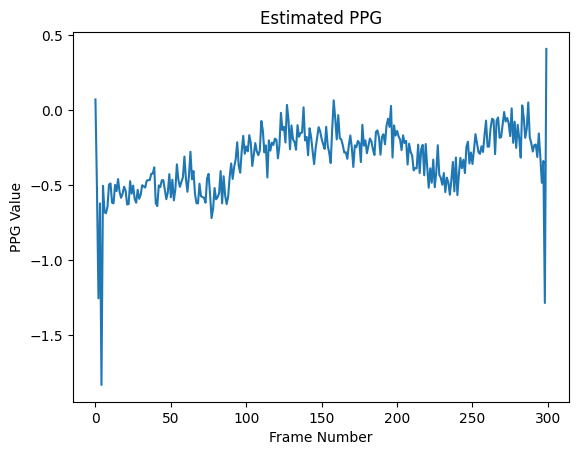

In [31]:
plt.figure()
plt.plot(output_ppg.cpu().detach().numpy())
plt.title("Estimated PPG")
plt.xlabel("Frame Number")
plt.ylabel("PPG Value")
plt.show()

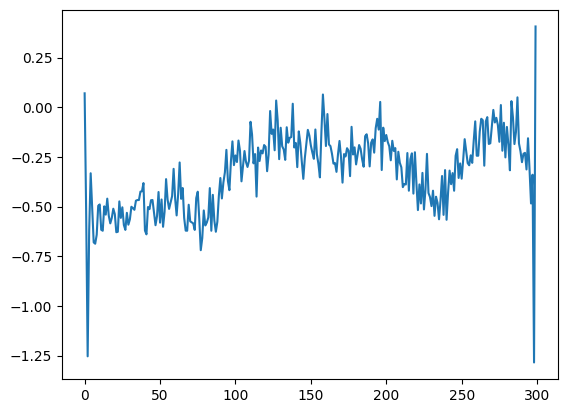

In [32]:
# out = [-10, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, -4, 5, 12, 15, 2]
out = output_ppg.cpu().detach().numpy()
mean = np.mean(out)
std = np.std(out)
dist_param = 5
for each in range(len(out)):
    if out[each] > mean + dist_param*std or out[each] < mean - dist_param*std:
        out[each] = mean

out = torch.tensor(out)
plt.plot(out.cpu().detach().numpy())


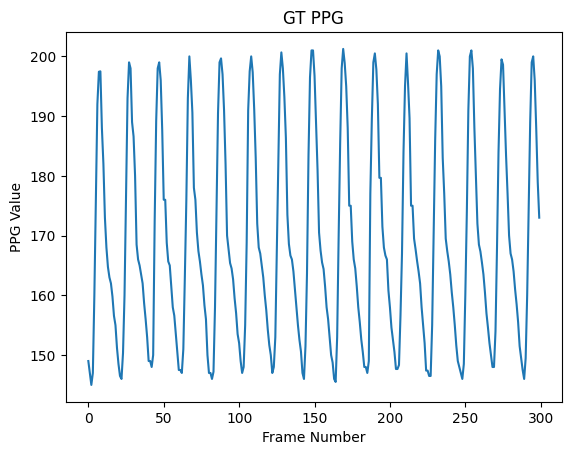

In [33]:
plt.figure()
plt.plot(ppg_sig[0:300])
plt.title("GT PPG")
plt.xlabel("Frame Number")
plt.ylabel("PPG Value")
plt.show()

In [34]:
def normalize_ppg(ppg_sig):
    return (ppg_sig - np.mean(ppg_sig))/np.std(ppg_sig)

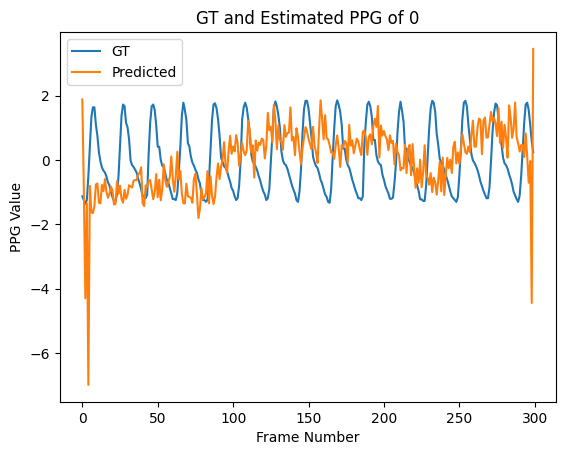

In [35]:
plt.figure()
plt.plot(normalize_ppg(ppg_sig[0:300]), label="GT")
plt.plot(normalize_ppg(output_ppg.cpu().detach().numpy()), label="Predicted")
plt.title("GT and Estimated PPG of 0")
plt.xlabel("Frame Number")
plt.ylabel("PPG Value")
plt.legend()
plt.show()

# Training

## Loss Functions

In [36]:
import torch
import matplotlib.pyplot as plt
import argparse,os
import pandas as pd
import numpy as np
import random
import math
from torchvision import transforms

class Neg_Pearson(nn.Module):    # Pearson range [-1, 1] so if < 0, abs|loss| ; if >0, 1- loss
    def __init__(self):
        super(Neg_Pearson,self).__init__()
        return
    def forward(self, preds, labels):       # tensor [Batch, Temporal]
        loss = 0
        for i in range(preds.shape[0]):
            sum_x = torch.sum(preds[i])                # x
            sum_y = torch.sum(labels[i])               # y
            sum_xy = torch.sum(preds[i]*labels[i])        # xy
            sum_x2 = torch.sum(torch.pow(preds[i],2))  # x^2
            sum_y2 = torch.sum(torch.pow(labels[i],2)) # y^2
            N = preds.shape[1]
            pearson = (N*sum_xy - sum_x*sum_y)/(torch.sqrt((N*sum_x2 - torch.pow(sum_x,2))*(N*sum_y2 - torch.pow(sum_y,2))+1e-2))

            #if (pearson>=0).data.cpu().numpy():    # torch.cuda.ByteTensor -->  numpy
            #    loss += 1 - pearson
            #else:
            #    loss += 1 - torch.abs(pearson)
            
            loss += 1 - pearson

            # print((N*sum_x2 - torch.pow(sum_x,2)),(N*sum_y2 - torch.pow(sum_y,2)))
            
            
        loss = loss/preds.shape[0]
        # print(loss)
        return loss

In [37]:
def find_peaks_and_troughs(signal):
    peaks = []
    troughs = []
    for i in range(7, len(signal)-7):
        if signal[i] == max(signal[i-7:i+7]):
            peaks.append(i)
        elif signal[i] == min(signal[i-7:i+7]):
            troughs.append(i)
    return peaks, troughs

class Peak_Trough_loss(nn.Module):
    def __init__(self):
        super(Peak_Trough_loss, self).__init__()
        
    def forward(self, y_pred, y_true):
        peaks, troughs = find_peaks_and_troughs(y_true)
        loss = 0
        for peak in peaks:
            loss += torch.abs(y_pred[peak] - y_true[peak])
        for trough in troughs:
            loss += torch.abs(y_pred[trough] - y_true[trough])
        return loss*0.5

In [38]:
class MSE_NegPearson_Loss(nn.Module):
    def __init__(self):
        super(MSE_NegPearson_Loss, self).__init__()

    def forward(self, y_pred, y_true):
        mse_loss = nn.MSELoss()(y_pred, y_true)
        neg_pearson = Neg_Pearson()(y_pred, y_true)
        loss = mse_loss + neg_pearson
        return loss

In [39]:
class MSE_NegPearson_Peaks(nn.Module):
    def __init__(self):
        super(MSE_NegPearson_Loss, self).__init__()

    def forward(self, y_pred, y_true):
        mse_loss = nn.MSELoss()(y_pred, y_true) * 0 # Zero this for testing of sorts
        neg_pearson = Neg_Pearson()(y_pred, y_true)
        peak_trough = Peak_Trough_loss()(y_pred, y_true)
        loss = mse_loss + neg_pearson + peak_trough
        return loss

## Actual Training

In [40]:
device = torch.device("cuda")
model = CNN3D_rppg_d().to(device)

In [41]:
# Loss Function
# loss_fn  = torch.nn.MSELoss()
loss_fn = Neg_Pearson()
# Use GPU for model training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Gradient Descent Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# A high number to remember the best Loss.
best_loss = np.inf
# Num Epochs to train for 
epoch_start = 1
epochs = 5

In [ ]:
for epoch in range(epoch_start, epochs+1):
    # Training Phase
    loss_train = 0
    no_batches = 0
    for batch, (imgs, signal) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        model.train()
        # Convert to the appropriate format and mount on the specified device
        # For imgs, this has to be done in the model itself. 
        # signal = signal[:,0:-1].to(device)
        signal = signal.to(device)
        signal = signal - torch.mean(signal)

        # Predict the PPG signal and find the loss
        pred_signal = model(imgs)
        # pred_signal = pred_signal.permute(1,0)

        # print(pred_signal.shape)
        # print(signal.shape)
        loss = loss_fn(pred_signal, signal)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the total loss
        loss_train += loss.item()
        no_batches+=1

        # if(batch==50):
        #   break



    # You may want to add in two functionalities after each epoch:
    # 1. Evaluate your model on a small validation set to see how the model is doing
    # 2. Save the model if it does well on the validation set

    print(f"Epoch: {epoch} ; Loss: {loss_train/no_batches:>7f}")
    if (loss_train/no_batches < .13 and epoch%2 == 1) or loss_train == np.nan:
      break

In [ ]:
print(loss, pred_signal, signal)

In [ ]:
loss = loss_fn(pred_signal, signal)
print(loss)

In [ ]:
# You can plot the Ground-truth and Predicted signals in a batch to check how the model is doing qualitatively. 
a = (signal[1,:].cpu().detach().numpy())
a = (a-np.mean(a))/np.std(a)
b = (pred_signal[1,:].cpu().detach().numpy())
b = (b-np.mean(b))/np.std(b)
plt.plot(a)
plt.plot(b)

# Evaluation

In [55]:
(hr_ests, hr_gts), lmd_vals = eval_rgb_model(root_dir, test_set, model, rgb_transform_func=transform_img)

Evaluation Starting!


100%|██████████| 62/62 [01:39<00:00,  1.61s/it]


Calculating HR from PPGs


 26%|██▌       | 16/62 [00:00<00:02, 20.86it/s]

failed to estimate HR for  /content/dataset/training_data/subject_58_5


100%|██████████| 62/62 [00:03<00:00, 20.28it/s]


In [ ]:
l, m, d, all = get_all_lmd_errors(hr_ests, hr_gts, lmd_vals)

In [ ]:
torch.save(model.state_dict(), os.path.join(os.getcwd(), f"best_model_ckpt.pth"))
print("Saved Checkpoint!")

# Explainers:

Here is the code with plots to show what happens every layer

In [ ]:
class CNN3D_rppg_d(nn.Module):
# todo: activation layers
    def __init__(self, sequence_length=64, in_channels=4, device=torch.device("cuda"), 
                 num_filters=16, kernel_size=3, pool_size=(2, 2), nb_dense=128):
        """Definition of CNN3D_rppg.
        Args:
          in_channels: the number of input channel. Default: 3
        Returns:
          CNN3D_rppg model.
        """
        super(CNN3D_rppg_d, self).__init__()

        self.sequence_length=sequence_length
        self.use_gpu = True
        self.device = device

        self.color_layer = nn.Parameter(torch.tensor([0.531 , 0.59, 0.6], dtype=torch.float32, device=self.device), requires_grad=True)
        
        self.cnn1 = torch.nn.Conv3d(in_channels, 32, kernel_size=3, padding=1)
        self.bn_layer1 = torch.nn.BatchNorm3d(32)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn2 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer2 = torch.nn.BatchNorm3d(32)
        self.relu2 = torch.nn.ReLU()
        self.maxpool2 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn3 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer3 = torch.nn.BatchNorm3d(32)
        self.relu3 = torch.nn.ReLU()
        self.maxpool3 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn4 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer4 = torch.nn.BatchNorm3d(32)
        self.relu4 = torch.nn.ReLU()
        self.maxpool4 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.cnn5 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer5 = torch.nn.BatchNorm3d(32)
        self.relu5 = torch.nn.ReLU()
        self.maxpool5 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))
        
        self.cnn6 = torch.nn.Conv3d(32, 32, kernel_size=3, padding=1)
        self.bn_layer6 = torch.nn.BatchNorm3d(32)
        self.relu6 = torch.nn.ReLU()
        self.maxpool6 = torch.nn.MaxPool3d((1,2,2), stride=(1,2,2))

        self.finalcnn = torch.nn.Conv1d(32, 1, kernel_size=3, padding=1)
        # self.bn_finallayer = torch.nn.BatchNorm3d(1)

    def forward(self, inputs, params=None):
        # Notice how the inputs are converted to Tensors and reshaped within the forward pass.
        # Typically, it is done outside of the forward pass, but since different projects may have 
        # different input shapes, we leave it to you to define it within here. 
        # That way, the evaluation function will work for everyone. 
        # inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        # inputs = torch.squeeze(inputs, dim=0)
        # inputs = torch.permute(inputs, dims=(0,3,1,2))

        # inputs = (BxTxHxWxC)
        #new_input = (BxCxTxHxW)
        
        # inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device)
        dims = inputs.shape
        # Lets look at sample shape: 2, 128, 64, 64, 3

        inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device) # -> This shape is (2, 128, 64, 64, 3)
        # print('ddfsdf', inputs.shape)
        inputs = torch.reshape(inputs, (inputs.shape[0]*inputs.shape[1], inputs.shape[2], inputs.shape[3], inputs.shape[4])) # -> This shape is (256, 64, 64, 3)
        # print('rrrrrr', inputs.shape)
        x = torch.einsum('ijkl, l -> ijk', inputs, self.color_layer) # -> This shape is (256, 64, 64)
        # We now have this new color layer which is a scalar value for each pixel in the image
        # We want to add this to the existing 3 color channels to get a 4 channel image

        inputs = torch.cat((inputs, x.unsqueeze(3)), dim=3) # -> This shape is (256, 64, 64, 4)

        # We want to get the the shape back to the original shape of (2, 128, 64, 64, 1), where the last dimension is the color layer which is a scalar value after the dot product
        x = torch.reshape(inputs, (dims[0], dims[1], dims[2], dims[3], 4)) # -> This shape is (2, 128, 64, 64, 1)

        plt.imshow(x[0, 0, :, :, 0].detach().cpu().numpy(), cmap='gray')
        plt.title("A ")
        plt.show()
        plt.imshow(x[0, 0, :, :, 1].detach().cpu().numpy(), cmap='gray')
        plt.title("B ")
        plt.show()
        plt.imshow(x[0, 0, :, :, 2].detach().cpu().numpy(), cmap='gray')
        plt.title("C ")
        plt.show()
        plt.imshow(x[0, 0, :, :, 3].detach().cpu().numpy(), cmap='gray')
        plt.title("D ")
        plt.show()

        x = torch.permute(x, dims=tuple(torch.tensor([0, 4, 1, 2, 3])))


        x = self.cnn1(x)
        for i in range(32):
            plt.imshow(x[0, i, 0, :, :].detach().cpu().numpy(), cmap='gray')
            plt.title("Layer 1, Filter " + str(i))
            plt.show()
        x = self.bn_layer1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.cnn2(x)
        for i in range(32):
            plt.imshow(x[0, i, 0, :, :].detach().cpu().numpy(), cmap='gray')
            plt.title("Layer 1, Filter " + str(i))
            plt.show()
        x = self.bn_layer2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.cnn3(x)
        for i in range(32):
            plt.imshow(x[0, i, 0, :, :].detach().cpu().numpy(), cmap='gray')
            plt.title("Layer 1, Filter " + str(i))
            plt.show()
        x = self.bn_layer3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = self.cnn4(x)
        for i in range(32):
            plt.imshow(x[0, i, 0, :, :].detach().cpu().numpy(), cmap='gray')
            plt.title("Layer 1, Filter " + str(i))
            plt.show()
        x = self.bn_layer4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.cnn5(x)
        for i in range(32):
            plt.imshow(x[0, i, 0, :, :].detach().cpu().numpy(), cmap='gray')
            plt.title("Layer 1, Filter " + str(i))
            plt.show()
        x = self.bn_layer5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)

        x = self.cnn6(x)
        for i in range(32):
            plt.imshow(x[0, i, 0, :, :].detach().cpu().numpy(), cmap='gray')
            plt.title("Layer 1, Filter " + str(i))
            plt.show()
        x = self.bn_layer6(x)
        x = self.relu6(x)
        x = self.maxpool6(x)

        x = torch.squeeze(x) 

        x = self.finalcnn(x)
        # x = self.bn_finallayer(x)
        # x = relu(x)
        x = torch.squeeze(x)

        outputs = x

        # # Sanjits edits
        # print(outputs.shape)

        # out = output_ppg.cpu().detach().numpy()
        # mean = np.mean(out)
        # std = np.std(out)
        # dist_param = 5
        # for each in range(len(out)):
        #     if out[each].any() > mean + dist_param*std or out[each].any() < mean - dist_param*std:
        #         outputs[each] = torch.from_numpy(np.array(mean))

        # print(outputs.shape)

        # End of Sanjits edits

        return outputs

In [49]:
# Change the below path to where the <training_data.zip> folder is on your Google Drive
!cp -r /content/drive/MyDrive/189_team_folder/Explainers_et_al/vid_thing /content/vid_thing
!cp /content/drive/MyDrive/189_team_folder/Explainers_et_al/512.pth /content/3DCNN.pth

In [50]:
path = 'vid_thing'
file_str = "test.mp4"
video = extract_video(path, file_str, length=900)

<ipython-input-23-5c6fd5b3ac8b>:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32, device=self.device) # -> This shape is (2, 128, 64, 64, 3)


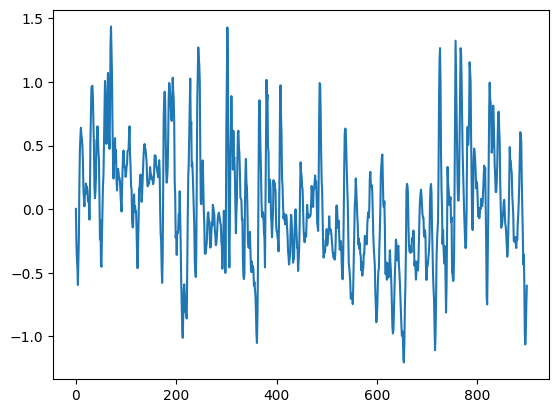

In [51]:
# Explainers, We want to use explainers to see what each layer does

# model = CNN3D_rppg_d()
# model.load_state_dict(torch.load('/content/3DCNN.pth'))
# model = model.cuda()

video_tensor = torch.from_numpy(video).unsqueeze(0).float().cuda()

output = model(video_tensor)
output = output.cpu().squeeze(0).detach().numpy()

# Lets plot the ppg signal
plt.plot(output)
plt.show()